[View in Colaboratory](https://colab.research.google.com/github/karwer/GMGridView/blob/master/zen.ipynb)

In [0]:
originalOuterRadius = 120.0
lanes = 5
allSegments = 60
dataSegments = 54

In [0]:
import cv2
import numpy as np
filename = 'im_grayscale_20.jpg'
image = cv2.imread(filename)

In [0]:
grayscaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
sharpness = cv2.Laplacian(grayscaled, cv2.CV_64F).var()
print(sharpness)

1714.1290104968334


In [0]:
blurred = cv2.GaussianBlur(grayscaled, (9, 9), 2, 2)

In [67]:
import math

def computeProduct(p1, p2, p3):
  v1 = (p2[0] - p1[0], p2[1] - p1[1])
  v2 = (p3[0] - p2[0], p3[1] - p2[1])
  d1 = math.sqrt(v1[0]*v1[0] + v1[1]*v1[1])
  d2 = math.sqrt(v2[0]*v2[0] + v2[1]*v2[1])
  return (v1[0] * v2[0] + v1[1] * v2[1]) / (d1 * d2)

def curvy(contour):
  approx = cv2.approxPolyDP(contour, 3, True)
  points = [(c[0][0], c[0][1]) for c in approx]
  if len(points) < 5:
    return False
  # print(points)
  previous = (points[0], points[1])
  products = []
  for point in points[2:]:
    product = computeProduct(previous[0], previous[1], point)
    products += [product]
    previous = (previous[1], point)
  products += [computeProduct(points[-1], points[0], points[1])]
  if len(points) == 180:
    print(points)
    print(products)
    print(products[123])
    print(points[123:126])
  if all(map(lambda x: x > 0.0, products)):
    return True
  else:
    return False

# Contours
(_, flat) = cv2.threshold(grayscaled, 96, 255, cv2.THRESH_BINARY)
(imContour, contours, hierarchy) = cv2.findContours(flat, 1, 2)

curvedContours = list(filter(curvy, contours))
print(len(curvedContours))

approxContours = []
for contour in contours:
  approx = cv2.approxPolyDP(contour, 3, True)
  approxContours += [approx]

contourLengths = [(index, len(contour)) for (index, contour) in enumerate(approxContours)]
contourLengths.sort(key=lambda tup: -tup[1])
print(contourLengths)
  
contoursToDraw = [approxContours[8592]]
#contoursToDraw = curvedContours
  
contoured = image.copy()
cv2.drawContours(contoured, contoursToDraw, -1, (0,255,0), 1);


[(605, 464), (704, 473), (714, 483), (707, 496), (593, 489), (585, 495), (580, 511), (558, 516), (547, 515), (536, 499), (499, 506), (432, 534), (426, 543), (427, 561), (403, 579), (405, 603), (386, 619), (377, 619), (369, 610), (371, 601), (392, 581), (383, 568), (356, 586), (329, 613), (327, 621), (334, 640), (318, 660), (327, 684), (311, 706), (290, 705), (278, 726), (279, 735), (290, 745), (290, 754), (273, 808), (290, 825), (288, 843), (281, 853), (265, 859), (265, 918), (249, 928), (250, 959), (234, 971), (253, 1035), (257, 1039), (276, 1040), (292, 1064), (312, 1064), (328, 1084), (350, 1083), (369, 1100), (382, 1094), (389, 1096), (403, 1111), (398, 1131), (409, 1142), (419, 1144), (433, 1136), (452, 1148), (454, 1159), (442, 1177), (442, 1184), (458, 1195), (468, 1195), (482, 1184), (503, 1191), (516, 1178), (540, 1183), (545, 1202), (598, 1210), (606, 1196), (616, 1190), (675, 1185), (721, 1170), (729, 1171), (741, 1182), (762, 1173), (761, 1154), (779, 1141), (793, 1147), (7

In [7]:
circles = cv2.HoughCircles( blurred, cv2.HOUGH_GRADIENT, 1, blurred.shape[0] / 8, param1=200, param2=100, minRadius=10, maxRadius=0 )
print(circles)
circle = circles[0][0] # change if there are more than one circle - select the largest one
center = tuple(circle[:2])
radius = circle[2]

[[[608.5 879.5 409.9]]]


In [0]:
# Prepare circles output
circleOutput = cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB)

cv2.circle(circleOutput, center, radius, (0, 255, 0));

In [0]:
verticalScale = 5
radiusCorrection = 1.34
dSize = (int(radiusCorrection * radius), 360 * verticalScale)
linear = cv2.warpPolar(blurred, dSize, center, radiusCorrection * radius, cv2.INTER_CUBIC)
outerRadius = radius
innerRadius = 0.75 * radius
laneWidth = (outerRadius - innerRadius) / lanes

In [0]:
(_, flat) = cv2.threshold(linear, 96, 255, cv2.THRESH_BINARY)

In [0]:
# find data lane
import numpy as np

left = int(innerRadius)
right = int(outerRadius)

datalane = flat[:, left:right+1]
pixelRows = np.sum(255-datalane, axis=1)
if pixelRows[0] == 0:
  nonZeroRows = np.where(pixelRows > 0)
  firstNonZeroRow = nonZeroRows[0][0]
else:
  firstZeroRow = np.where(pixelRows == 0)[0][0]
  nonZeroRows = np.where(pixelRows[firstZeroRow:] > 0)
  firstNonZeroRow = nonZeroRows[0][0] + firstZeroRow
data = np.concatenate((flat[firstNonZeroRow:], flat[:firstNonZeroRow]), axis=0)

In [0]:
# find data rows
markerRadius = 0.25 * outerRadius
angle = np.arcsin(markerRadius / (outerRadius - markerRadius))
top = int(verticalScale * np.degrees(angle))
bottom = top + int(dataSegments * verticalScale * 360 / allSegments);

In [0]:
# Prepare grid output
gridOutput = cv2.cvtColor(data, cv2.COLOR_GRAY2RGB)

currentRadius = outerRadius
for i in range(lanes+1):
  cv2.line(gridOutput, (int(currentRadius), 0), (int(currentRadius), linear.shape[0]), (0, 255, 0));
  currentRadius -= laneWidth
currentRow = top
segmentSize = verticalScale * (360 / allSegments)
for i in range(dataSegments+1):
  cv2.line(gridOutput, (int(innerRadius), int(currentRow)), (int(outerRadius), int(currentRow)), (0, 255, 0));
  currentRow += segmentSize

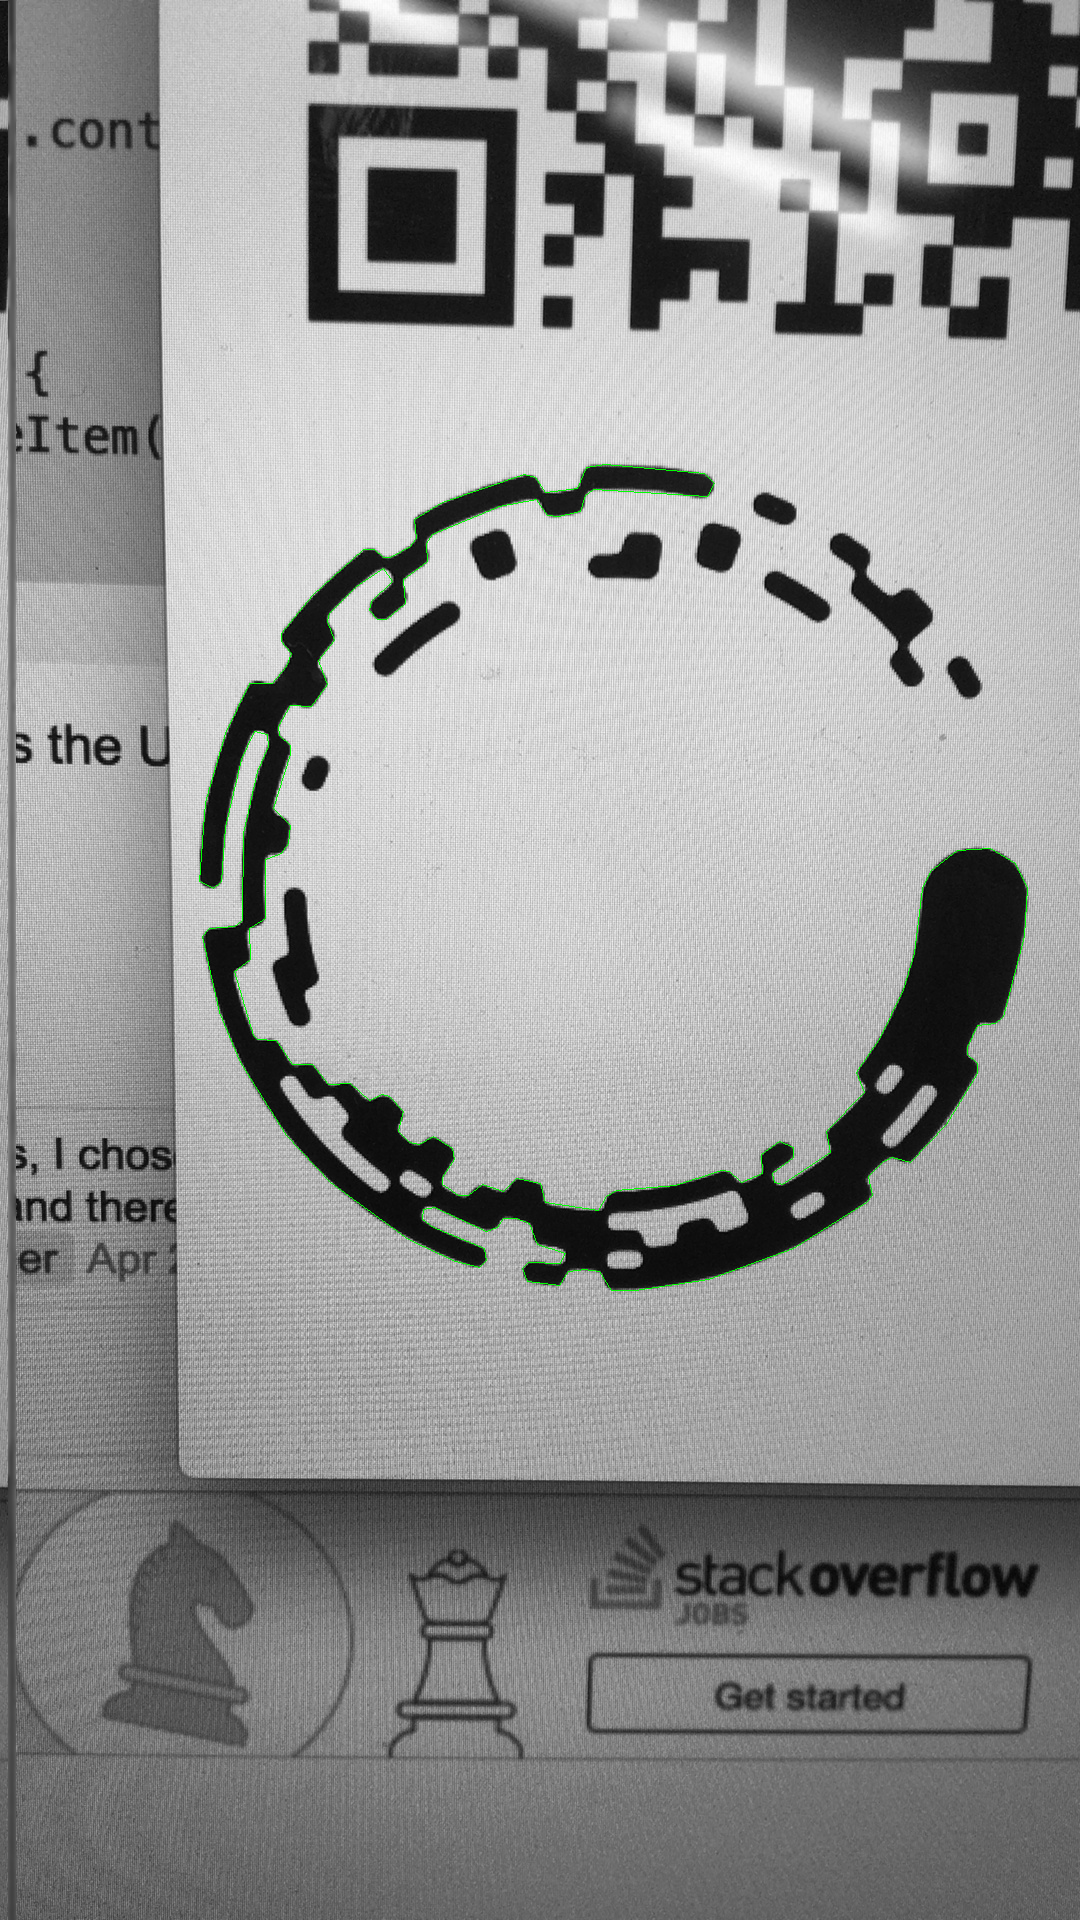

In [68]:
output = contoured

cv2.imwrite("out.png", output)
from PIL import Image as PIL_Image
PIL_Image.open('out.png')